In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
from pandas.plotting import scatter_matrix

# Guide 

- For data visualization see the file `data_visualization.ipynb`
- The preprocessing is done in the file `preprocessing.ipynb`
- The benchmark model is in the file `benchmark.ipynb`

# Regression

In [2]:
%load_ext autoreload
%autoreload 2

import math  # for sqrt
from statistics import mean

import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score, train_test_split

#!wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
from andrea_models import AndreaLinearRegression  # In the course library
from dataset import get_dataset
from preprocessing import preprocessData

In [10]:
df_train, df_test = preprocessData(*get_dataset())
target = 't0s0'


all_cols = df_train.columns.tolist()
all_features = all_cols.copy()
all_features.remove(target)

In [11]:
all_features_model = AndreaLinearRegression()
all_features_model.fit(df_train.drop(columns=[target]), df_train[target], column_names=all_features)
all_features_model.summary()

prediction = all_features_model.predict(df_test[all_features])

RMSE_all_features = math.sqrt(mean_squared_error(df_test[target], prediction))
print('='*50)
print('RMSE now: ', RMSE_all_features)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 1.726e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:07:02   Log-Likelihood:                 31398.
No. Observations:               21783   AIC:                        -6.278e+04
Df Residuals:                   21773   BIC:                        -6.270e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

The RMSE is relatively high, maybe this is happening because there are hight correlated features.

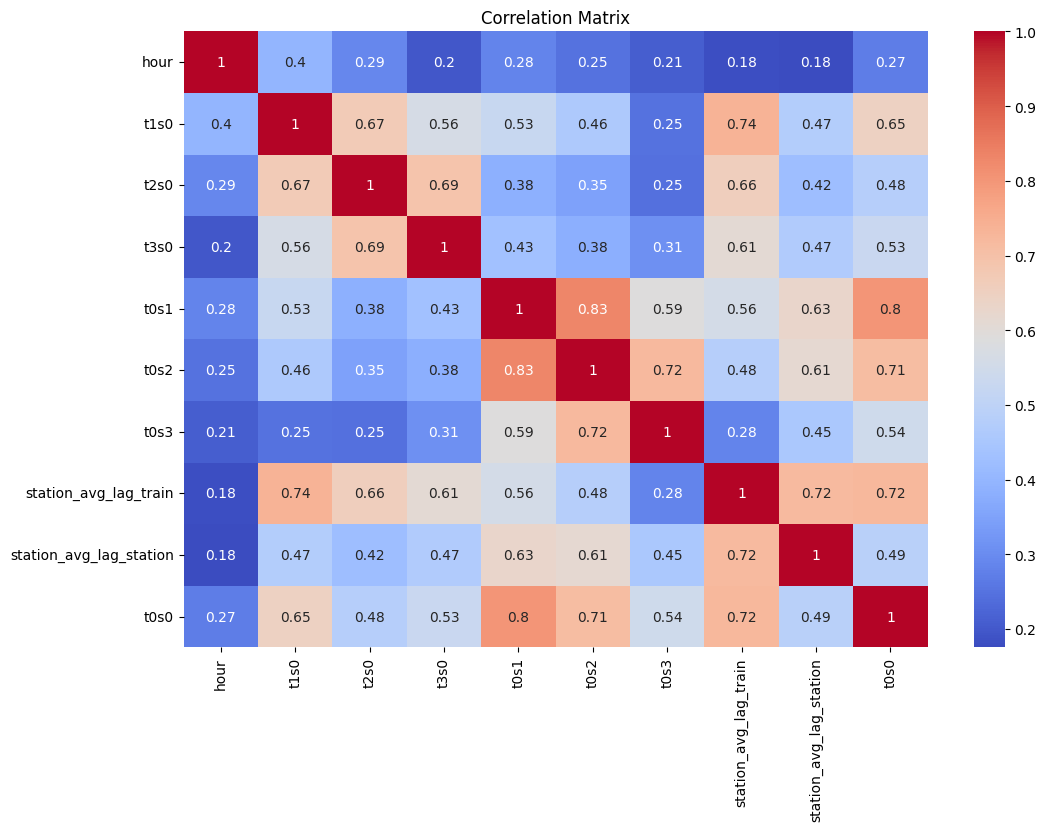

In [68]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[all_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [33]:
#! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/feature_engineering.py
import feature_engineering

features_corr = feature_engineering.get_features_correlated_to_target(
    df_train[all_cols], target_feature='t0s0')

features_corr_df = features_corr.reset_index()
features_corr_df.columns = ['Feature', 'Correlation']


# drop the target feature
features_corr_df = features_corr_df[features_corr_df['Feature'] != target]
features_corr_df

,Feature,Correlation
1,t0s1,0.87
2,t0s2,0.85
3,station_avg_lag_train,0.72
4,t1s0,0.70
5,t0s3,0.66
6,t2s0,0.55
7,t3s0,0.43
8,station_avg_lag_station,0.39
9,hour,0.18


In [12]:
from tqdm.notebook import tqdm

# Lets make a grid search to find the best features to drop
# Try all combinations of features
import itertools
import heapq

all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = AndreaLinearRegression()
    model.fit(df_train[list(comb)], df_train[target], column_names=list(comb))
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05920887486360957
Combination: ('hour', 't1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05922090654682381
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05923434334462683
Combination: ('t1s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05926288299179956
Combination: ('t1s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05928780681758344
Combination: ('hour', 't1s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.05931749672738357
Combination: ('hour', 't1s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.059336694829518206
Combination: ('hour', 't0s1', 't0

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.877
Method:                 Least Squares   F-statistic:                 2.213e+04
Date:                Wed, 18 Dec 2024   Prob (F-statistic):               0.00
Time:                        10:37:01   Log-Likelihood:                 31369.
No. Observations:               21783   AIC:                        -6.272e+04
Df Residuals:                   21775   BIC:                        -6.266e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
intercept                 

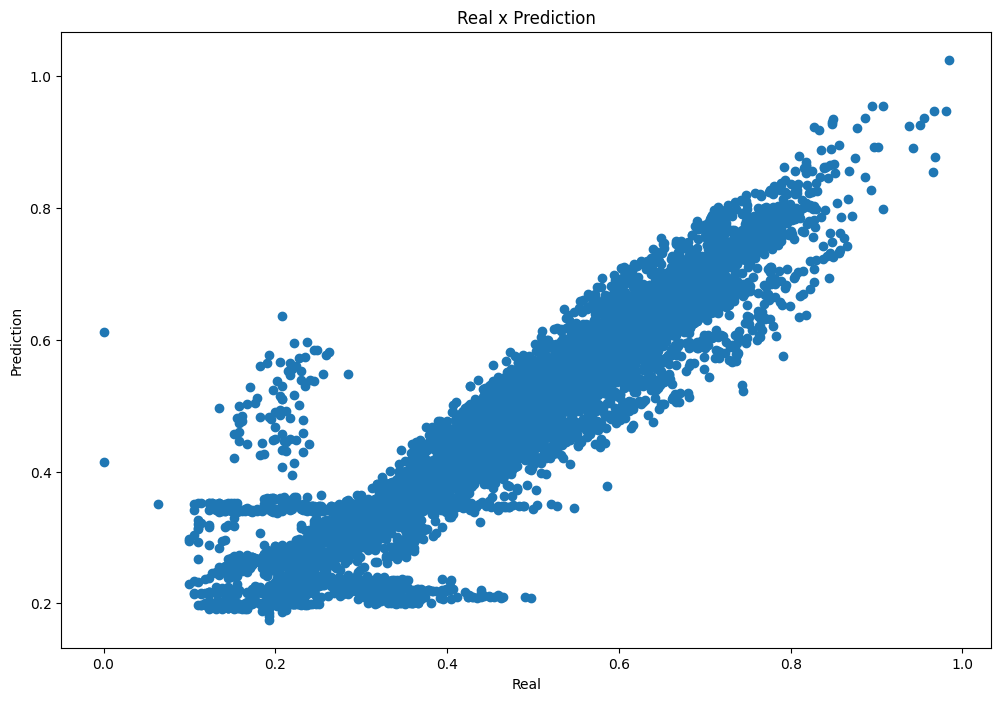

In [18]:
model = AndreaLinearRegression()

# get cols from the best solution
best_comb = list(('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'))


model.fit(df_train[best_comb], df_train[target], column_names=list(best_comb))

model.summary()

prediction = model.predict(df_test[best_comb])
error = math.sqrt(mean_squared_error(df_test[target], prediction))
print(f"RMSE: {error}")

# print prediction x real
plt.figure(figsize=(12, 8))
plt.scatter(df_test[target], prediction)
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.title('Real x Prediction')
plt.show()

# Nearest Neighbors regression

In [98]:
# Nearest Neighbors regression
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
model.fit(df_train[all_features], df_train[target])
prediction = model.predict(df_test[all_features])
error = math.sqrt(mean_squared_error(df_test[target], prediction))
print(f"RMSE: {error}")


RMSE: 0.04520462101636907


# Polinomial regression

In [20]:
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


In [100]:
parameters_to_test = {'polynomialfeatures__degree': np.arange(1, 5)}
k_fold = KFold(n_splits=5, shuffle=True, random_state=6)


def MyPolynomialRegression(degree=2, include_bias=False):
    return make_pipeline(PolynomialFeatures(degree=degree, include_bias=include_bias),
                         AndreaLinearRegression())


grid = GridSearchCV(MyPolynomialRegression(), parameters_to_test,
                    cv=k_fold, scoring='neg_mean_squared_error')


grid.fit(df_train[all_features], df_train[target])

GridSearchCV(cv=KFold(n_splits=5, random_state=6, shuffle=True),
             estimator=Pipeline(steps=[('polynomialfeatures',
                                        PolynomialFeatures(include_bias=False)),
                                       ('andrealinearregression',
                                        AndreaLinearRegression())]),
             param_grid={'polynomialfeatures__degree': array([1, 2, 3, 4])},
             scoring='neg_mean_squared_error')

In [101]:
print('Best parameters:', grid.best_params_)
print('Best score:', math.sqrt(mean(-grid.cv_results_['mean_test_score'])))

model = grid.best_estimator_

model.fit(df_train[all_features], df_train[target])
prediction = model.predict(df_test[all_features])

print("RMSE: ", np.sqrt(mean_squared_error(df_test[target], prediction)))

Best parameters: {'polynomialfeatures__degree': 4}
Best score: 0.044239137909288136
RMSE:  0.15880866003811045


In [103]:
all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=3),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04058724792089237
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.041687434805268354
Combination: ('t2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.042332453769116526
Combination: ('t1s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04282299558199237
Combination: ('t2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.043213383478894675
Combination: ('t1s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04371860686225482
Combination: ('t3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04372093688118991
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s3', 'station_

In [105]:
all_combinations = []
for i in range(1, len(all_features)):
    all_combinations.extend(itertools.combinations(all_features, i))

solutions = []
for i, comb in enumerate(tqdm(all_combinations, desc="Grid Search")):
    model = make_pipeline(PolynomialFeatures(degree=4),
                          AndreaLinearRegression())
    model.fit(df_train[list(comb)], df_train[target])
    prediction = model.predict(df_test[list(comb)])
    error = math.sqrt(mean_squared_error(df_test[target], prediction))
    heapq.heappush(solutions, (error, comb))

# Get the best 10 solutions
best_solutions = heapq.nsmallest(10, solutions)
print("Best 10 solutions:")
for error, comb in best_solutions:
    print(f"Combination: {comb}, RMSE: {error}")

Grid Search:   0%|          | 0/510 [00:00<?, ?it/s]

Best 10 solutions:
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.03934238618806583
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04074896849279701
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04090645900843036
Combination: ('t1s0', 't2s0', 't3s0', 't0s1', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.0411039012320505
Combination: ('t2s0', 't3s0', 't0s1', 't0s2', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04223669938743459
Combination: ('t1s0', 't2s0', 't0s1', 't0s2', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04262710136527029
Combination: ('t1s0', 't3s0', 't0s1', 't0s2', 't0s3', 'station_avg_lag_train', 'station_avg_lag_station'), RMSE: 0.04268277832623546
Combination: ('t2s0', 't3s0', 't0s1', 't0s3', 'station_avg_

Text(0.5, 1.0, 'Real x Prediction')

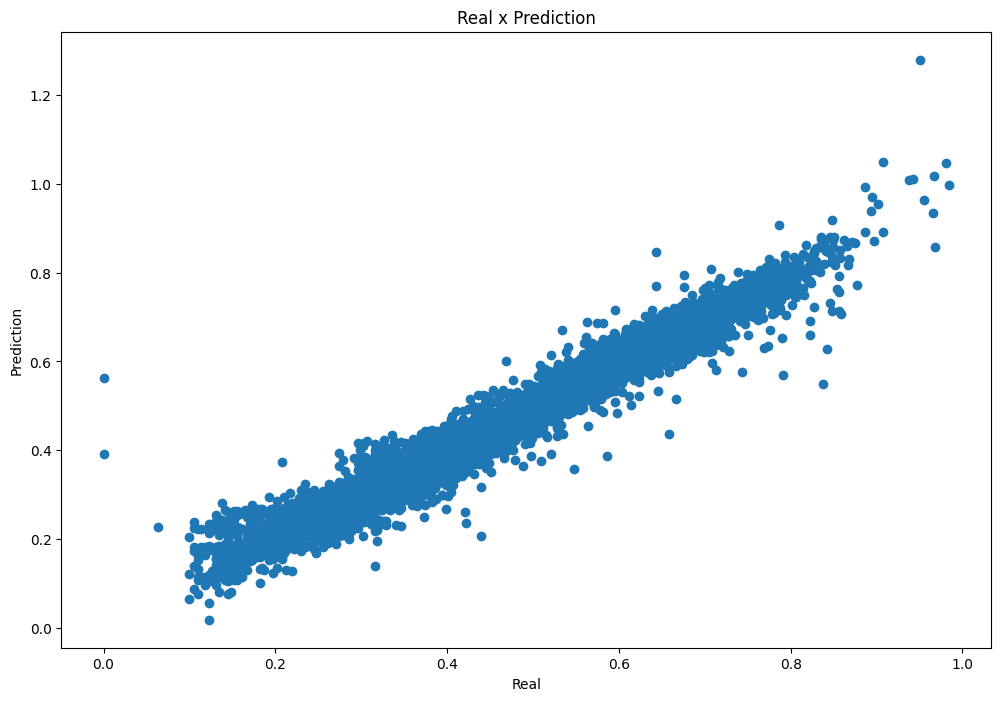

In [25]:
# plot prediction x real
best_comb = list(('t1s0', 't2s0', 't3s0', 't0s1', 't0s2', 'station_avg_lag_train', 'station_avg_lag_station'))
model = make_pipeline(PolynomialFeatures(degree=4),
                      AndreaLinearRegression())
model.fit(df_train[best_comb], df_train[target])

prediction = model.predict(df_test[best_comb])

plt.figure(figsize=(12, 8))
plt.scatter(df_test[target], prediction)
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.title('Real x Prediction')

# Random Forest

In [35]:
from sklearn.ensemble import RandomForestRegressor
from visualization import plot_feature_importances

In [36]:
# Initialize the Random Forest Regressor
rf_model = RandomForestRegressor(
    n_estimators=200, random_state=42, criterion='squared_error')

# Fit the model
rf_model.fit(df_train[all_features], df_train[target])

# Predict on the test set
rf_prediction = rf_model.predict(df_test[all_features])

# Calculate RMSE
RMSE_rf = np.sqrt(mean_squared_error(df_test[target], rf_prediction))
print('RMSE Random Forest:', RMSE_rf)

RMSE Random Forest: 0.024732049408290862


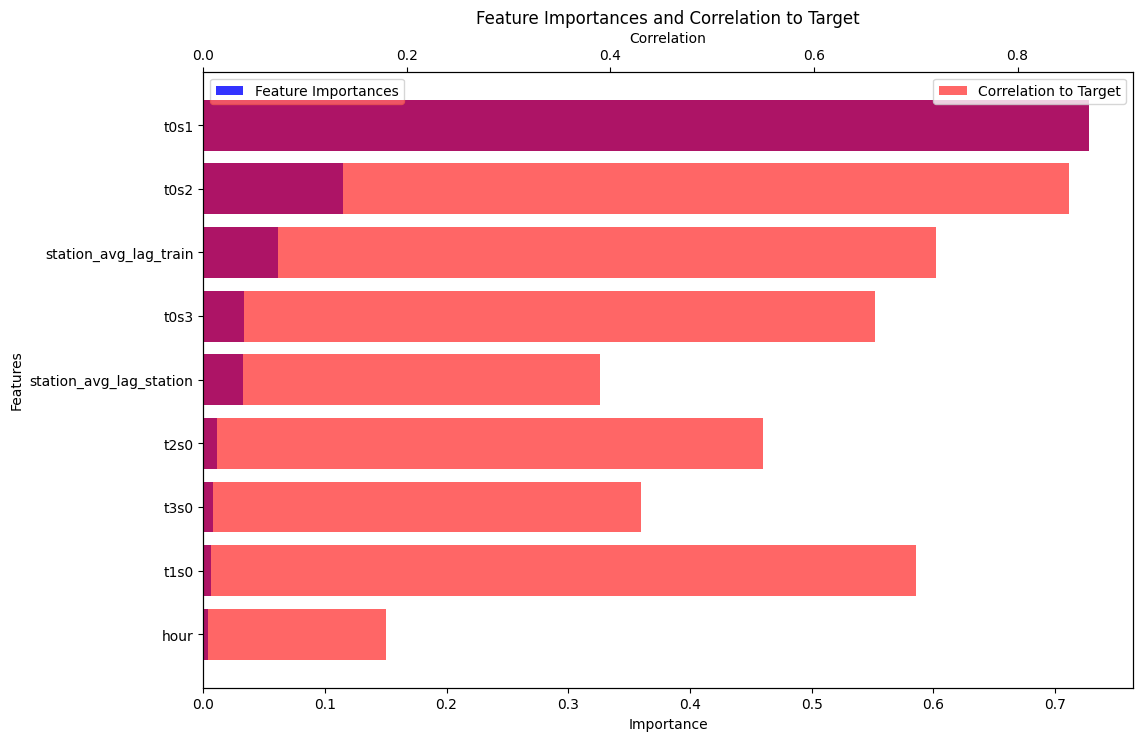

In [43]:
fig, ax1 = plt.subplots(figsize=(12, 8))

# Get the order of indices based on feature importances
indices = np.argsort(rf_model.feature_importances_)

# Plot feature importances
ax1.barh(np.array(all_features)[indices], rf_model.feature_importances_[indices], color='b', alpha=0.8, label='Feature Importances')
ax1.set_xlabel('Importance')
ax1.set_ylabel('Features')
ax1.set_title('Feature Importances and Correlation to Target')

# Plot correlation of features to the target
ax2 = ax1.twiny()
ax2.barh(features_corr_df['Feature'], features_corr_df['Correlation'], color='r', alpha=0.6, label='Correlation to Target')
ax2.set_xlabel('Correlation')

# Add legends
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

plt.show()

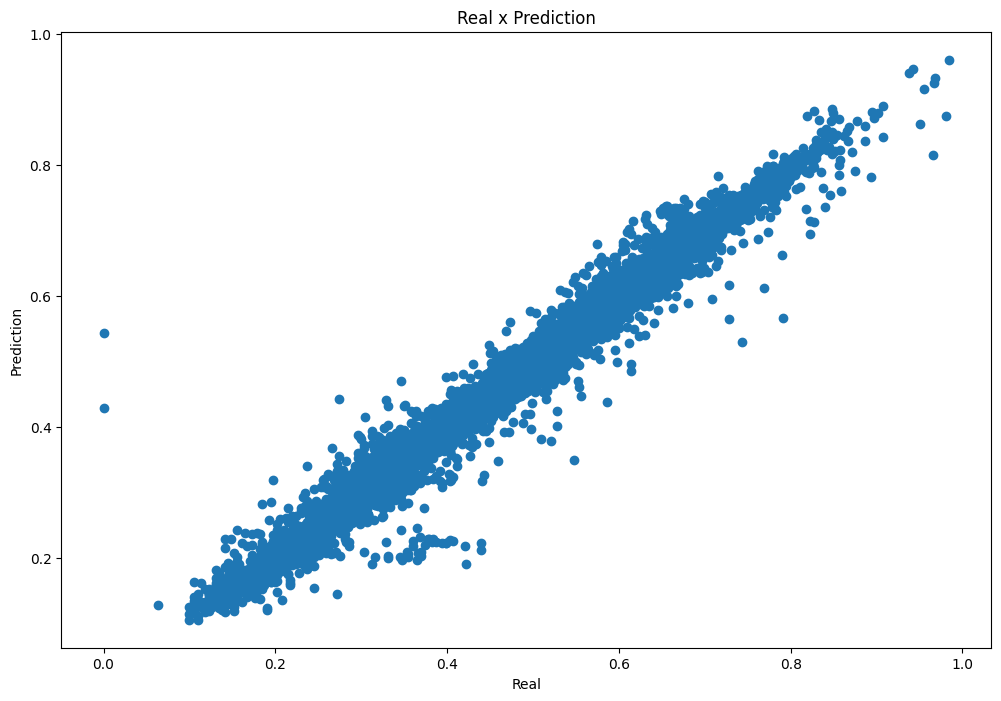

In [10]:
# plot prediction x real
plt.figure(figsize=(12, 8))
plt.scatter(df_test[target], rf_prediction)
plt.xlabel('Real')
plt.ylabel('Prediction')
plt.title('Real x Prediction')
plt.show()


# Neural Network

In [ ]:
from train_code import make_sequential_model, train_model
from functools import partial, partialmethod

n_features = len(all_features)
make_model = partial(make_sequential_model, sample_size=n_features,
                      hidden_activation_function="relu",
                      out_activation_function="relu",
                      loss_fun='mean_squared_error',
                      metrics=[])

first_architecture = [10, 10, 10, 1]
model = make_model(layer_sizes=first_architecture)

In [ ]:
from google.colab import drive

mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'MLN/'

In [ ]:
nn_file = my_path + 'nn1-lr_1.001.keras'
history = train_model(model, nn_file, df_train[all_features], df_train[target], seed=10,
                      max_epochs=200)

In [ ]:
prediction = model.predict(df_test[all_features])
RMSE_all_features = math.sqrt(mean_squared_error(df_test[target], prediction))
print('='*50)
print('RMSE now: ', RMSE_all_features)

# Autogluon

In [114]:
#! pip install autogluon
from autogluon.tabular import TabularPredictor

In [115]:
predictor = TabularPredictor(label='t0s0').fit(train_data=df_train)
predictions = predictor.predict(df_test)

No path specified. Models will be saved in: "AutogluonModels/ag-20241218_020335"
Verbosity: 2 (Standard Logging)
=================== System Info ===================
AutoGluon Version:  1.2
Python Version:     3.10.12
Operating System:   Linux
Platform Machine:   x86_64
Platform Version:   #49~22.04.1-Ubuntu SMP PREEMPT_DYNAMIC Wed Nov  6 17:42:15 UTC 2
CPU Count:          8
Memory Avail:       5.56 GB / 19.41 GB (28.7%)
Disk Space Avail:   832.28 GB / 930.26 GB (89.5%)
No presets specified! To achieve strong results with AutoGluon, it is recommended to use the available presets. Defaulting to `'medium'`...
	Recommended Presets (For more details refer to https://auto.gluon.ai/stable/tutorials/tabular/tabular-essentials.html#presets):
	presets='experimental' : New in v1.2: Pre-trained foundation model + parallel fits. The absolute best accuracy without consideration for inference speed. Does not support GPU.
	presets='best'         : Maximize accuracy. Recommended for most users. Use in 

[1000]	valid_set's rmse: 0.0210236
[2000]	valid_set's rmse: 0.0199478
[3000]	valid_set's rmse: 0.01955
[4000]	valid_set's rmse: 0.0193786
[5000]	valid_set's rmse: 0.0192819
[6000]	valid_set's rmse: 0.0192247
[7000]	valid_set's rmse: 0.0192137
[8000]	valid_set's rmse: 0.0191946
[9000]	valid_set's rmse: 0.0191718
[10000]	valid_set's rmse: 0.0191773


	-0.0192	 = Validation score   (-root_mean_squared_error)
	8.56s	 = Training   runtime
	0.7s	 = Validation runtime
Fitting model: LightGBM ...


[1000]	valid_set's rmse: 0.0197337
[2000]	valid_set's rmse: 0.0196163


	-0.0196	 = Validation score   (-root_mean_squared_error)
	2.01s	 = Training   runtime
	0.07s	 = Validation runtime
Fitting model: RandomForestMSE ...
	-0.0199	 = Validation score   (-root_mean_squared_error)
	9.25s	 = Training   runtime
	0.11s	 = Validation runtime
Fitting model: CatBoost ...
	-0.0191	 = Validation score   (-root_mean_squared_error)
	72.02s	 = Training   runtime
	0.01s	 = Validation runtime
Fitting model: ExtraTreesMSE ...
	-0.0187	 = Validation score   (-root_mean_squared_error)
	3.44s	 = Training   runtime
	0.1s	 = Validation runtime
Fitting model: NeuralNetFastAI ...
	-0.0211	 = Validation score   (-root_mean_squared_error)
	20.73s	 = Training   runtime
	0.03s	 = Validation runtime
Fitting model: XGBoost ...
	-0.0199	 = Validation score   (-root_mean_squared_error)
	1.66s	 = Training   runtime
	0.05s	 = Validation runtime
Fitting model: NeuralNetTorch ...
	-0.024	 = Validation score   (-root_mean_squared_error)
	33.5s	 = Training   runtime
	0.01s	 = Validation runt

In [116]:
predictor = TabularPredictor.load("/media/arthur/HD/Users/arthu/projetos/machine-learning-for-networks/project/AutogluonModels/ag-20241218_020335")
predictor.evaluate(df_test)

{'root_mean_squared_error': -0.031346784762831335,
 'mean_squared_error': -0.0009826209149672747,
 'mean_absolute_error': -0.02239422781856402,
 'r2': 0.963500464955214,
 'pearsonr': 0.9842913712986614,
 'median_absolute_error': -0.01656180486517883}

In [117]:
predictor.leaderboard(df_test)

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,RandomForestMSE,-0.024396,-0.019901,root_mean_squared_error,0.686977,0.108544,9.254866,0.686977,0.108544,9.254866,1,True,5
1,ExtraTreesMSE,-0.024477,-0.018736,root_mean_squared_error,0.448991,0.097672,3.435236,0.448991,0.097672,3.435236,1,True,7
2,LightGBMLarge,-0.024611,-0.019569,root_mean_squared_error,0.201780,0.034971,2.347198,0.201780,0.034971,2.347198,1,True,11
3,LightGBM,-0.025638,-0.019585,root_mean_squared_error,0.266941,0.072797,2.014610,0.266941,0.072797,2.014610,1,True,4
4,NeuralNetFastAI,-0.029749,-0.021116,root_mean_squared_error,0.183188,0.029520,20.725370,0.183188,0.029520,20.725370,1,True,8
5,WeightedEnsemble_L2,-0.031347,-0.018407,root_mean_squared_error,3.905693,0.831822,104.763329,0.004926,0.000539,0.022436,2,True,12
6,NeuralNetTorch,-0.032278,-0.024021,root_mean_squared_error,0.033585,0.007105,33.500321,0.033585,0.007105,33.500321,1,True,10
7,XGBoost,-0.038991,-0.019866,root_mean_squared_error,0.126947,0.050614,1.656089,0.126947,0.050614,1.656089,1,True,9
8,KNeighborsDist,-0.044738,-0.022732,root_mean_squared_error,0.159225,0.025850,0.029562,0.159225,0.025850,0.029562,1,True,2
9,KNeighborsUnif,-0.044965,-0.023166,root_mean_squared_error,0.170249,0.025306,0.033418,0.170249,0.025306,0.033418,1,True,1
